In [ ]:
%pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks
!unzip -qq -o open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 153.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.7 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
 80% 294M/367M [00:00<00:00, 855MB/s] 
100% 367M/367M [00:00<00:00, 628MB/s]


In [ ]:
# make directory to where the images are located
IMAGE_ROOT = 'images/images'
# read the csv file with image metadata
DF_RAW = pd.read_csv('df.csv')
# view the first five rows
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
import cv2
# create a dataset to match images to their boundig boxes, class, path and IDs
class OpenImages(Dataset):
  def __init__(self, df, image_folder=IMAGE_ROOT):
    # define the folder containing the images
    self.root = image_folder
    # define the df containing image metadata
    self.df = df
    # select unique images
    self.unique_images = df['ImageID'].unique()

  def __len__(self):
    # return the length of the dataset
    return len(self.unique_images)

  def __getitem__(self, ix):
    # get the image_id of the image at the current index
    image_id = self.unique_images[ix]
    # get the file path of the image at the current inndex
    image_path = f'{self.root}/{image_id}.jpg'
    # read the image and convert the color channels to RGB
    image = cv2.imread(image_path, 1)[...,::-1]
    # get the image height and width
    h, w, _ = image.shape
    # make a copy of the df
    df = self.df.copy()
    # select the row containing metadata to the image in the current index
    df = df[df['ImageID'] == image_id]
    # get the bounding box coordinates
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    # change the coordinates from their normalized form
    boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
    # get the classname of the image
    classes = df['LabelName'].values.tolist()
    return image, boxes, classes, image_path

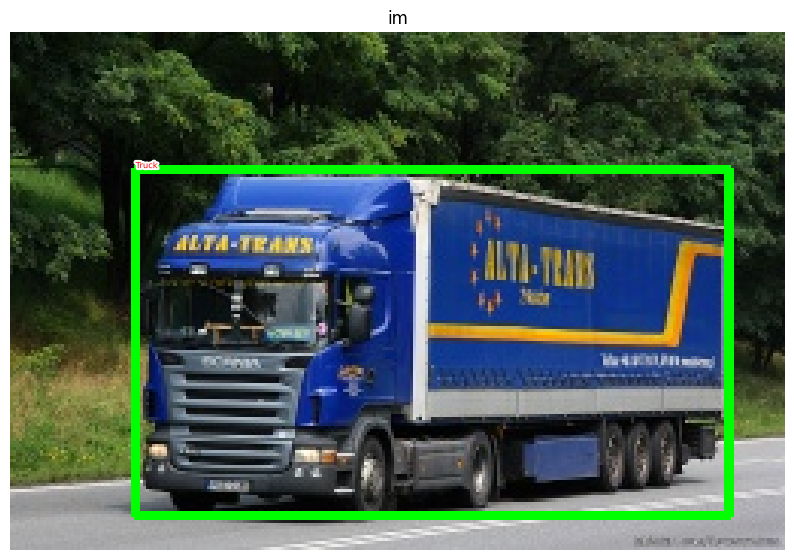

In [ ]:
# define dataset
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [ ]:
# make a function to obtain region proposals
def extract_candidates(img):
  # extract region proposals using selective search
  img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  # calculate the area of the image
  img_area = np.prod(img.shape[:2])
  # define a list to store the coordinates of bouning boxes or proposed regions
  candidates = []
  for r in regions:
    # skip any duplicate region
    if r['rect'] in candidates: continue
    # filter out regions that are too small
    if r['size'] < (0.05*img_area): continue
    # filter out regions that are too large... size of all of the image
    if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    # add the suited region coordinates in the candidates list
    candidates.append(list(r['rect']))
  return candidates

In [ ]:
examples = extract_candidates(im)

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [ ]:
# create a function to calculate the intersection over union
def extract_iou(boxA, boxB, epsilon=1e-5):
  # define the coordinates
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[2], boxB[3])
  # obtain the width and the height
  width = (x2 -x1)
  height = (y2 - y1)
  if (width < 0) or (height < 0):
    return 0.0
  # calculate the area of intersection between the two boxes
  area_overlap = width * height
  # culculate the area of box a
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  # calculate the total area of the two boxes, subtract the overlap area to avoid doubling it
  area_combined = area_a + area_b - area_overlap
  # calculate the iou
  iou = area_overlap / (area_combined + epsilon) # epsilon used to avoid division by zero error incase area_combined is zero
  return iou

In [ ]:
# Calculate IOU between the example bounding box and each bounding box in the bbs list
ious = [extract_iou(example, bb) for example in examples for bb in bbs]
print(ious)

[0.02121553755552747, 1.1906228858737524, 0.0, 0.575613886211903, 0.575613886211903, 0.6941526444667878, 0.0, 0.03032046291823611, 0.01794158552714808, -0.07088094898805218, 0.01794158552714808, 0.01794158552714808, -0.14033412898992373, 0.07239282002057419, 1.1658514888103593, 0.12319777265480171, 3.2247011887954162, 0.0, 0.0, 0.0, 0.6461604951403541, 0.6941526444667878, 0.07254901957397338, 1.4549703384370212, 1.0685796264617027, 0.7819993765322335, 1.1553090322034967, 1.1553090322034967, 1.0305921968631826, 0.0, 0.789401165592863, 1.401315788260634, 1.0305921968631826, 1.401315788260634, 1.401315788260634, 1.3364193811852716, 0.5545792999368132, -0.20227038201089645, 1.2517647051810843, 1.09529411711015, 0.5154325258326569]


In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [ ]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  img = normalize(img) # Apply the normalize transform
  return img.to(device).float()
def decode(_y):
  _, preds = _y.max(-1)
  return preds

In [ ]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [ ]:
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
from torchvision.ops import RoIPool
class FRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    rawnet = torchvision.models.vgg16_bn(pretrained=True)
    for param in rawnet.features.parameters():
      param.requires_grad = True
    self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
    self.roipool = RoIPool(7, spatial_scale=14/224)
    feature_dim = 512*7*7
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 4),
        nn.Tanh(),
    )
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()

  def forward(self, input, rois, ridx):
    res = input
    res = self.seq(res)
    rois = torch.cat([ridx.unsqueeze(-1), rois*224],  dim=1)
    res = self.roipool(res, rois)
    feat = res.view(len(res), -1)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cel(probs, labels)
    ixs, = torch.where(labels != background_class)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas, deltas)
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
  batch_inputs, rois, rixs, clss, deltas = inputs # Renamed 'input' to 'batch_inputs'
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(batch_inputs, rois, rixs) # Use 'batch_inputs' here
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas) # corrected to use clss and deltas from inputs
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
def validate_batch(inputs, model, criterion):
  input, rois, rixs, clss, deltas = inputs
  with torch.no_grad():
    model.eval()
    _clss,_deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    _clss = decode(_clss)
    accs = clss == _clss
  return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 1.000  val_loc_loss: 0.691  val_regr_loss: 0.111  trn_loc_loss: 0.935  trn_loss: 2.208  trn_acc: 0.576  val_acc: 0.748  val_loss: 1.806  trn_regr_loss: 0.127  (13.83s - 55.33s remaining)
EPOCH: 2.000  val_loc_loss: 0.624  val_regr_loss: 0.104  trn_loc_loss: 0.694  trn_loss: 1.604  trn_acc: 0.734  val_acc: 0.751  val_loss: 1.669  trn_regr_loss: 0.091  (26.56s - 39.84s remaining)
EPOCH: 3.000  val_loc_loss: 0.593  val_regr_loss: 0.105  trn_loc_loss: 0.563  trn_loss: 1.275  trn_acc: 0.801  val_acc: 0.749  val_loss: 1.642  trn_regr_loss: 0.071  (38.72s - 25.81s remaining)
EPOCH: 4.000  val_loc_loss: 0.577  val_regr_loss: 0.108  trn_loc_loss: 0.467  trn_loss: 1.081  trn_acc: 0.845  val_acc: 0.754  val_loss: 1.653  trn_regr_loss: 0.061  (50.81s - 12.70s remaining)
EPOCH: 5.000  val_loc_loss: 0.569  val_regr_loss: 0.102  trn_loc_loss: 0.394  trn_loss: 0.942  trn_acc: 0.878  val_acc: 0.756  val_loss: 1.592  trn_regr_loss: 0.055  (62.80s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 3999.46it/s]


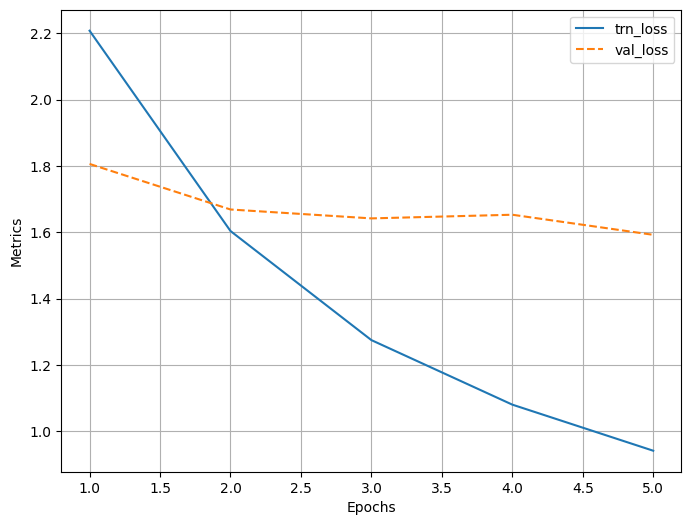

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]

    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

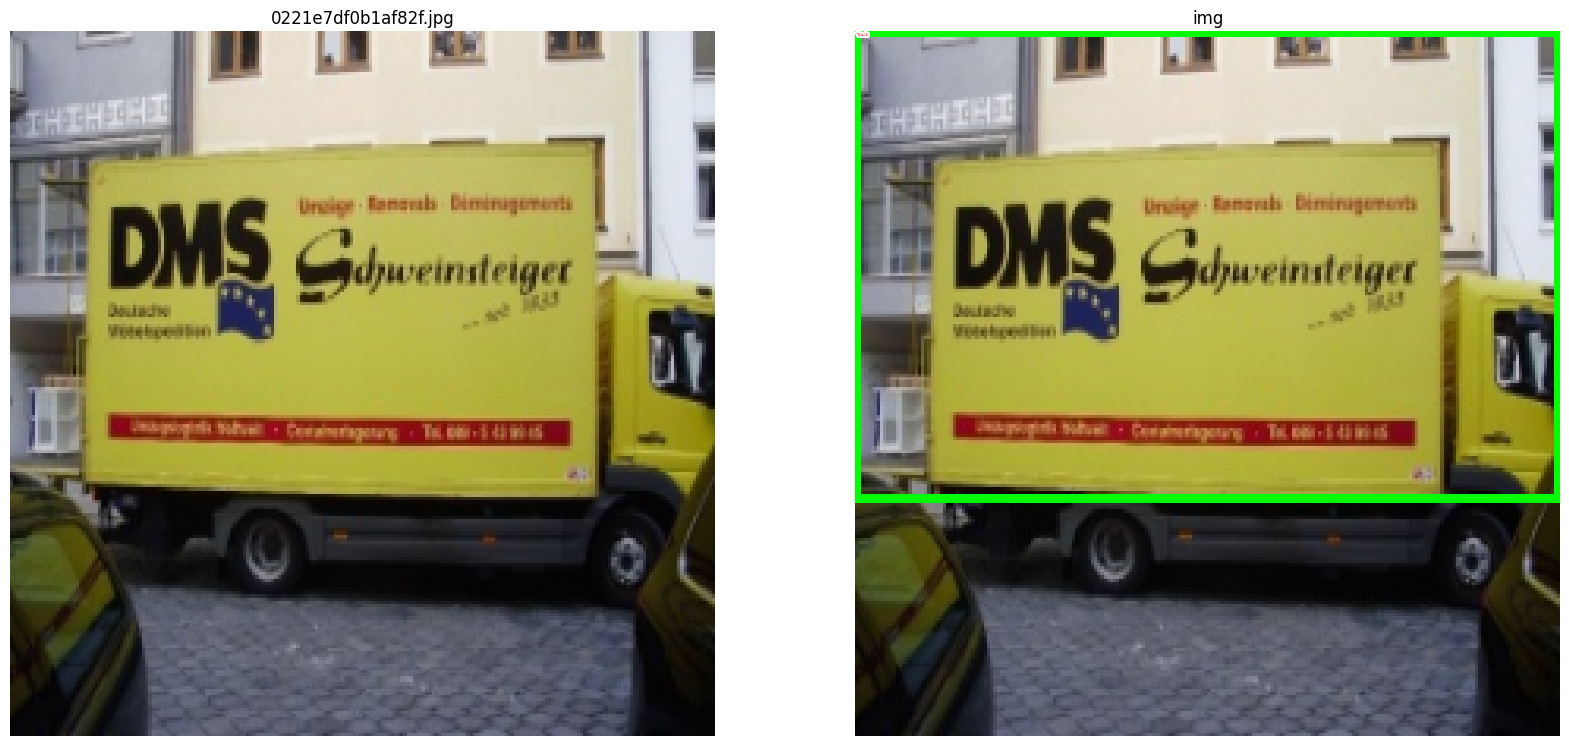

In [ ]:
test_predictions(test_ds[30][-1])